In [6]:
import numpy as np
import torch


class Trainer:
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset = None,
                 lr_scheduler: torch.optim.lr_scheduler = None,
                 epochs: int = 100,
                 epoch: int = 0,
                 ):

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs
        self.epoch = epoch
        self.training_loss = []
        self.validation_loss = []
        self.learning_rate = []

    def run_trainer(self):
        from tqdm import tqdm, trange

        progressbar = trange(self.epochs, desc='Progress')
        for i in progressbar:
            """Epoch counter"""
            self.epoch += 1  # epoch counter

            """Training block"""
            self._train()

            """Validation block"""
            if self.validation_DataLoader is not None:
                self._validate()

            """Learning rate scheduler block"""
            if self.lr_scheduler is not None:
                if self.validation_DataLoader is not None and self.lr_scheduler.__class__.__name__ == 'ReduceLROnPlateau':
                    self.lr_scheduler.batch(self.validation_loss[i])  # learning rate scheduler step with validation loss
                else:
                    self.lr_scheduler.batch()  # learning rate scheduler step
        return self.training_loss, self.validation_loss, self.learning_rate

    def _train(self):
        from tqdm import tqdm, trange

        self.model.train()  # train mode
        train_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.training_DataLoader), 'Training', total=len(self.training_DataLoader),
                          leave=False)

        for i, (x, y) in batch_iter:
            input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
            self.optimizer.zero_grad()  # zerograd the parameters
            out = self.model(input)  # one forward pass
            loss = self.criterion(out, target)  # calculate loss
            loss_value = loss.item()
            train_losses.append(loss_value)
            loss.backward()  # one backward pass
            self.optimizer.step()  # update the parameters

            batch_iter.set_description(f'Training: (loss {loss_value:.4f})')  # update progressbar

        self.training_loss.append(np.mean(train_losses))
        self.learning_rate.append(self.optimizer.param_groups[0]['lr'])

        batch_iter.close()
        

    def _validate(self):
        from tqdm import tqdm, trange

        self.model.eval()  # evaluation mode
        valid_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.validation_DataLoader), 'Validation', total=len(self.validation_DataLoader),
                          leave=False)

        for i, (x, y) in batch_iter:
            input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

            with torch.no_grad():
                out = self.model(input)
                loss = self.criterion(out, target)
                loss_value = loss.item()
                valid_losses.append(loss_value)

                batch_iter.set_description(f'Validation: (loss {loss_value:.4f})')

        self.validation_loss.append(np.mean(valid_losses))

        batch_iter.close()

In [7]:
#Parameters
LR = 1e-4
batch_size = 4
num_epochs = 30
num_workers = 1
image_height = 256
image_width = 256
trainsize = 256
pin_memory = True
load_model = False



# device
device = "cuda" if torch.cuda.is_available() else "cpu"
# model
model = Res_UNet(n_channels = 3,n_classes = 1,bilinear = True).to(DEVICE)
# criterion
criterion = DiceBCELoss()
# optimizer
optimizer = optim.Adam(model.parameters(),lr = LR)

#DataPaths
base = "/content/drive/MyDrive/dataset/"
train_img_dir = base+"Train/Imgs/"
train_gt_dir = base+"Train/GT/"
val_img_dir = base+"Test/Imgs/"
val_gt_dir = base+"Test/GT/"

#Dataloaders
train_loader,val_loader = load_data(
    train_img_dir,
    train_gt_dir,
    val_img_dir,
    val_gt_dir,
    batch_size,
    trainsize,
    num_workers,
    pin_memory
)

# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=train_loader,
                  validation_DataLoader=val_loader,
                  lr_scheduler=None,
                  epochs=num_epochs,
                  epoch=0,)
# start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()

plot_training(training_losses,
                  validation_losses,
                  lr_rates,
                  gaussian=True,
                  sigma=1,
                  figsize=(8, 6)
                  )

Training:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")

Training: (loss 1.3530): 100%|██████████| 13/13 [00:08<00:00,  1.68it/s]
                                                                        
Training: (loss 1.0855): 100%|██████████| 13/13 [00:08<00:00,  1.66it/s]
                                                                        
Training: (loss 1.1266): 100%|██████████| 13/13 [00:08<00:00,  1.65it/s]
                                                                        
Training: (loss 1.2296): 100%|██████████| 13/13 [00:08<00:00,  1.65it/s]
                                                                        
Training: (loss 1.4746): 100%|██████████| 13/13 [00:08<00:00,  1.64it/s]
                                                                  

NameError: ignored

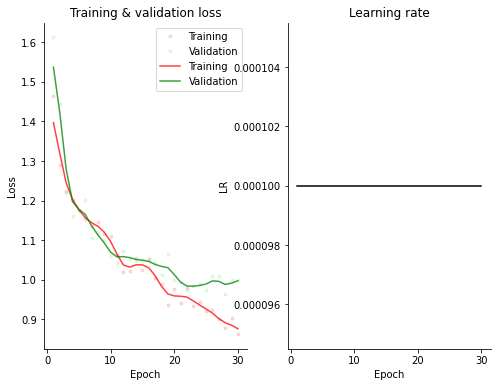

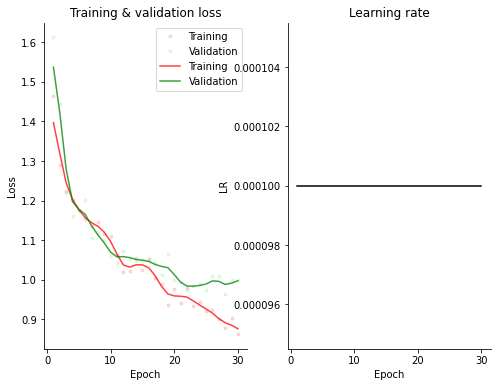

In [8]:
from visual import *
plot_training(training_losses,
                  validation_losses,
                  lr_rates,
                  gaussian=True,
                  sigma=1,
                  figsize=(8, 6)
                  )

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
# -*- coding: utf-8 -*-
"""Train.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1vIoRHVjlmgfiw2x0JQIJnpMM9cT33fX9
"""

from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
# from SegNet_normal import *
# from unet import *
from res_unetnormal import *
# from SegNet2 import *
from helpers import *
from loss import *
import numpy as np
import torchvision
from torchvision import transforms

LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 4
num_epochs = 30
num_workers = 1
image_height = 256
image_width = 256
trainsize = 256
pin_memory = True
load_model = False
base = "/content/drive/MyDrive/dataset/"
train_img_dir = base+"Train/Imgs/"
train_gt_dir = base+"Train/GT/"

val_img_dir = base+"Test/Imgs/"
val_gt_dir = base+"Test/GT/"


def train_fn(loader,model,optimizer,loss_fn,scaler):
  loop = tqdm(loader)

  for batch_idx, (data, targets) in enumerate(loop):
    data = data.to(device = DEVICE)
    targets = targets.float().to(device = DEVICE)

    # Forward pass
    with torch.cuda.amp.autocast():
      print(data.shape)
      predictions = model(data)
      loss = loss_fn(predictions,targets)
    # Backward Pass
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # Update to show progress

    loop.set_postfix(loss=loss.item())


def main():
    model = Res_UNet(n_channels = 3,n_classes = 1,bilinear = True).to(DEVICE)
    # model = SegNet(in_channels = 3,n_classes = 1,is_unpooling = True).to(DEVICE)
    loss_fn = DiceBCELoss()
    optimizer = optim.Adam(model.parameters(),lr = LR)

    train_loader,val_loader = load_data(
        train_img_dir,
        train_gt_dir,
        val_img_dir,
        val_gt_dir,
        batch_size,
        trainsize,
        num_workers,
        pin_memory
    )
    if load_model:
        load_checkpoint(torch.load("Ritwik_checkpoint.pth.tar"), model)
    get_metrics(val_loader,model,device=DEVICE)
    # save_predictions_as_imgs(val_loader, model, folder="saved_images/", device=DEVICE)
    scaler = torch.cuda.amp.GradScaler()
    for epoch in range(num_epochs):
      train_fn(train_loader,model,optimizer,loss_fn,scaler)
      checkpoint = {
          "state_dict":model.state_dict(),
          "optimizer":optimizer.state_dict()
      }
      save_checkpoint(checkpoint)
      get_metrics(val_loader,model,device=DEVICE)
      # save_predictions_as_imgs(val_loader, model, folder="saved_images/", device=DEVICE)
        

if __name__ == "__main__":
  main()

  0%|          | 0/13 [00:00<?, ?it/s]

Dice score: 0.3542201519012451
Sensitivity score: 0.7545806372403575
Specificity score: 0.5180569331409344
torch.Size([4, 3, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  8%|▊         | 1/13 [00:00<00:10,  1.17it/s, loss=1.54]

torch.Size([4, 3, 256, 256])


 15%|█▌        | 2/13 [00:01<00:09,  1.21it/s, loss=1.55]

torch.Size([4, 3, 256, 256])


 23%|██▎       | 3/13 [00:02<00:08,  1.25it/s, loss=1.54]

torch.Size([4, 3, 256, 256])


 31%|███       | 4/13 [00:03<00:07,  1.27it/s, loss=1.61]

torch.Size([4, 3, 256, 256])


 38%|███▊      | 5/13 [00:03<00:06,  1.28it/s, loss=1.4]

torch.Size([4, 3, 256, 256])


 46%|████▌     | 6/13 [00:04<00:05,  1.29it/s, loss=1.26]

torch.Size([4, 3, 256, 256])


 54%|█████▍    | 7/13 [00:05<00:04,  1.30it/s, loss=1.73]

torch.Size([4, 3, 256, 256])


 62%|██████▏   | 8/13 [00:06<00:03,  1.30it/s, loss=1.47]

torch.Size([4, 3, 256, 256])


 69%|██████▉   | 9/13 [00:06<00:03,  1.30it/s, loss=1.46]

torch.Size([4, 3, 256, 256])


 77%|███████▋  | 10/13 [00:07<00:02,  1.31it/s, loss=1.5]

torch.Size([4, 3, 256, 256])


 85%|████████▍ | 11/13 [00:08<00:01,  1.31it/s, loss=1.29]

torch.Size([4, 3, 256, 256])


 92%|█████████▏| 12/13 [00:09<00:00,  1.31it/s, loss=1.5]

torch.Size([2, 3, 256, 256])


  0%|          | 0/13 [00:00<?, ?it/s]

Dice score: 0.2981795072555542
Sensitivity score: 0.1841923520397516
Specificity score: 0.9645897734845629
torch.Size([4, 3, 256, 256])


  8%|▊         | 1/13 [00:00<00:10,  1.16it/s, loss=1.65]

torch.Size([4, 3, 256, 256])


 15%|█▌        | 2/13 [00:01<00:09,  1.20it/s, loss=1.17]

torch.Size([4, 3, 256, 256])


 23%|██▎       | 3/13 [00:02<00:08,  1.24it/s, loss=1.18]

torch.Size([4, 3, 256, 256])


 31%|███       | 4/13 [00:03<00:07,  1.26it/s, loss=1.53]

torch.Size([4, 3, 256, 256])


 38%|███▊      | 5/13 [00:03<00:06,  1.27it/s, loss=1.67]

torch.Size([4, 3, 256, 256])


 46%|████▌     | 6/13 [00:04<00:05,  1.28it/s, loss=1.55]

torch.Size([4, 3, 256, 256])


 54%|█████▍    | 7/13 [00:05<00:04,  1.29it/s, loss=1.42]

torch.Size([4, 3, 256, 256])


 62%|██████▏   | 8/13 [00:06<00:03,  1.30it/s, loss=1.3]

torch.Size([4, 3, 256, 256])


 69%|██████▉   | 9/13 [00:06<00:03,  1.30it/s, loss=1.12]

torch.Size([4, 3, 256, 256])


 77%|███████▋  | 10/13 [00:07<00:02,  1.30it/s, loss=1.35]

torch.Size([4, 3, 256, 256])


 85%|████████▍ | 11/13 [00:08<00:01,  1.31it/s, loss=1.29]

torch.Size([4, 3, 256, 256])


 92%|█████████▏| 12/13 [00:09<00:00,  1.31it/s, loss=1.14]

torch.Size([2, 3, 256, 256])


  0%|          | 0/13 [00:00<?, ?it/s]

Dice score: 0.40987691283226013
Sensitivity score: 0.2588454258853449
Specificity score: 0.9807388698685399
torch.Size([4, 3, 256, 256])


  8%|▊         | 1/13 [00:00<00:10,  1.17it/s, loss=1.32]

torch.Size([4, 3, 256, 256])


 15%|█▌        | 2/13 [00:01<00:09,  1.21it/s, loss=1.43]

torch.Size([4, 3, 256, 256])


 23%|██▎       | 3/13 [00:02<00:08,  1.24it/s, loss=1.19]

torch.Size([4, 3, 256, 256])


 31%|███       | 4/13 [00:03<00:07,  1.27it/s, loss=1.22]

torch.Size([4, 3, 256, 256])


 38%|███▊      | 5/13 [00:03<00:06,  1.27it/s, loss=1.4]

torch.Size([4, 3, 256, 256])


 46%|████▌     | 6/13 [00:04<00:05,  1.29it/s, loss=1.05]

torch.Size([4, 3, 256, 256])


 54%|█████▍    | 7/13 [00:05<00:04,  1.29it/s, loss=1.38]

torch.Size([4, 3, 256, 256])


 62%|██████▏   | 8/13 [00:06<00:03,  1.29it/s, loss=1.3]

torch.Size([4, 3, 256, 256])


 69%|██████▉   | 9/13 [00:06<00:03,  1.29it/s, loss=1.11]

torch.Size([4, 3, 256, 256])


 77%|███████▋  | 10/13 [00:07<00:02,  1.30it/s, loss=1.14]

torch.Size([4, 3, 256, 256])


 85%|████████▍ | 11/13 [00:08<00:01,  1.30it/s, loss=1.2]

torch.Size([4, 3, 256, 256])


 92%|█████████▏| 12/13 [00:09<00:00,  1.30it/s, loss=1.12]

torch.Size([2, 3, 256, 256])


  0%|          | 0/13 [00:00<?, ?it/s]

Dice score: 0.6674169898033142
Sensitivity score: 0.601899036468993
Specificity score: 0.952717010475522
torch.Size([4, 3, 256, 256])


  8%|▊         | 1/13 [00:00<00:10,  1.14it/s, loss=1.63]

torch.Size([4, 3, 256, 256])


 15%|█▌        | 2/13 [00:01<00:09,  1.18it/s, loss=1.33]

torch.Size([4, 3, 256, 256])


 23%|██▎       | 3/13 [00:02<00:08,  1.22it/s, loss=1.39]

torch.Size([4, 3, 256, 256])


 31%|███       | 4/13 [00:03<00:07,  1.24it/s, loss=1.08]

torch.Size([4, 3, 256, 256])


 38%|███▊      | 5/13 [00:03<00:06,  1.25it/s, loss=1.26]

torch.Size([4, 3, 256, 256])


 46%|████▌     | 6/13 [00:04<00:05,  1.27it/s, loss=1.34]

torch.Size([4, 3, 256, 256])


 54%|█████▍    | 7/13 [00:05<00:04,  1.28it/s, loss=1.27]

torch.Size([4, 3, 256, 256])


 62%|██████▏   | 8/13 [00:06<00:03,  1.29it/s, loss=1.03]

torch.Size([4, 3, 256, 256])


 69%|██████▉   | 9/13 [00:07<00:03,  1.29it/s, loss=1.16]

torch.Size([4, 3, 256, 256])


 77%|███████▋  | 10/13 [00:07<00:02,  1.29it/s, loss=1.31]

torch.Size([4, 3, 256, 256])


 85%|████████▍ | 11/13 [00:08<00:01,  1.30it/s, loss=1.03]

torch.Size([4, 3, 256, 256])


 92%|█████████▏| 12/13 [00:09<00:00,  1.30it/s, loss=1.14]

torch.Size([2, 3, 256, 256])


  0%|          | 0/13 [00:00<?, ?it/s]

Dice score: 0.6666873693466187
Sensitivity score: 0.735653616871981
Specificity score: 0.9085331192321736
torch.Size([4, 3, 256, 256])


  8%|▊         | 1/13 [00:00<00:10,  1.16it/s, loss=1.19]

torch.Size([4, 3, 256, 256])


 15%|█▌        | 2/13 [00:01<00:09,  1.20it/s, loss=1.64]

torch.Size([4, 3, 256, 256])


 23%|██▎       | 3/13 [00:02<00:08,  1.23it/s, loss=1.27]

torch.Size([4, 3, 256, 256])


 31%|███       | 4/13 [00:03<00:07,  1.24it/s, loss=1.44]

torch.Size([4, 3, 256, 256])


 38%|███▊      | 5/13 [00:03<00:06,  1.26it/s, loss=1.07]

torch.Size([4, 3, 256, 256])


 46%|████▌     | 6/13 [00:04<00:05,  1.27it/s, loss=1.06]

torch.Size([4, 3, 256, 256])


 54%|█████▍    | 7/13 [00:05<00:04,  1.28it/s, loss=1.08]

torch.Size([4, 3, 256, 256])


 62%|██████▏   | 8/13 [00:06<00:03,  1.28it/s, loss=1.22]

torch.Size([4, 3, 256, 256])


 69%|██████▉   | 9/13 [00:07<00:03,  1.28it/s, loss=1.06]

torch.Size([4, 3, 256, 256])


 77%|███████▋  | 10/13 [00:07<00:02,  1.29it/s, loss=1.44]

torch.Size([4, 3, 256, 256])


 85%|████████▍ | 11/13 [00:08<00:01,  1.29it/s, loss=1.04]

torch.Size([4, 3, 256, 256])


 92%|█████████▏| 12/13 [00:09<00:00,  1.30it/s, loss=1.21]

torch.Size([2, 3, 256, 256])


  0%|          | 0/13 [00:00<?, ?it/s]

Dice score: 0.6826136112213135
Sensitivity score: 0.8342023383164885
Specificity score: 0.8921514461173996
torch.Size([4, 3, 256, 256])


  8%|▊         | 1/13 [00:00<00:10,  1.15it/s, loss=1.06]

torch.Size([4, 3, 256, 256])


 15%|█▌        | 2/13 [00:01<00:09,  1.19it/s, loss=0.931]

torch.Size([4, 3, 256, 256])


 23%|██▎       | 3/13 [00:02<00:08,  1.22it/s, loss=1.34]

torch.Size([4, 3, 256, 256])


 31%|███       | 4/13 [00:03<00:07,  1.25it/s, loss=1.2]

torch.Size([4, 3, 256, 256])


 38%|███▊      | 5/13 [00:03<00:06,  1.26it/s, loss=1.52]

torch.Size([4, 3, 256, 256])


 46%|████▌     | 6/13 [00:04<00:05,  1.27it/s, loss=1.14]

torch.Size([4, 3, 256, 256])


 54%|█████▍    | 7/13 [00:05<00:04,  1.28it/s, loss=1.52]

torch.Size([4, 3, 256, 256])


 62%|██████▏   | 8/13 [00:06<00:03,  1.28it/s, loss=1.14]

torch.Size([4, 3, 256, 256])


 69%|██████▉   | 9/13 [00:07<00:03,  1.28it/s, loss=1.09]

torch.Size([4, 3, 256, 256])


 77%|███████▋  | 10/13 [00:07<00:02,  1.28it/s, loss=1.19]

torch.Size([4, 3, 256, 256])


 85%|████████▍ | 11/13 [00:08<00:01,  1.28it/s, loss=0.987]

torch.Size([4, 3, 256, 256])


 92%|█████████▏| 12/13 [00:09<00:00,  1.28it/s, loss=1.18]

torch.Size([2, 3, 256, 256])


  0%|          | 0/13 [00:00<?, ?it/s]

Dice score: 0.6679404973983765
Sensitivity score: 0.8382934963134773
Specificity score: 0.8784166033970311
torch.Size([4, 3, 256, 256])


  8%|▊         | 1/13 [00:00<00:10,  1.15it/s, loss=1.12]

torch.Size([4, 3, 256, 256])


 15%|█▌        | 2/13 [00:01<00:09,  1.19it/s, loss=1.1]

torch.Size([4, 3, 256, 256])


 23%|██▎       | 3/13 [00:02<00:08,  1.22it/s, loss=1.12]

torch.Size([4, 3, 256, 256])


 31%|███       | 4/13 [00:03<00:07,  1.24it/s, loss=1.04]

torch.Size([4, 3, 256, 256])


 38%|███▊      | 5/13 [00:03<00:06,  1.25it/s, loss=1.09]

torch.Size([4, 3, 256, 256])


 46%|████▌     | 6/13 [00:04<00:05,  1.27it/s, loss=1.2]

torch.Size([4, 3, 256, 256])


 54%|█████▍    | 7/13 [00:05<00:04,  1.28it/s, loss=1]

torch.Size([4, 3, 256, 256])


 62%|██████▏   | 8/13 [00:06<00:03,  1.28it/s, loss=1.4]

torch.Size([4, 3, 256, 256])


 69%|██████▉   | 9/13 [00:07<00:03,  1.28it/s, loss=1.27]

torch.Size([4, 3, 256, 256])


 77%|███████▋  | 10/13 [00:07<00:02,  1.29it/s, loss=1.03]

torch.Size([4, 3, 256, 256])


 85%|████████▍ | 11/13 [00:08<00:01,  1.29it/s, loss=1.18]

torch.Size([4, 3, 256, 256])


 92%|█████████▏| 12/13 [00:09<00:00,  1.29it/s, loss=1.05]

torch.Size([2, 3, 256, 256])


  0%|          | 0/13 [00:00<?, ?it/s]

Dice score: 0.7097815275192261
Sensitivity score: 0.6982179597061969
Specificity score: 0.9391019803122213
torch.Size([4, 3, 256, 256])


  8%|▊         | 1/13 [00:00<00:10,  1.14it/s, loss=1.17]

torch.Size([4, 3, 256, 256])


 15%|█▌        | 2/13 [00:01<00:09,  1.18it/s, loss=0.994]

torch.Size([4, 3, 256, 256])


 23%|██▎       | 3/13 [00:02<00:08,  1.21it/s, loss=1.12]

torch.Size([4, 3, 256, 256])


 31%|███       | 4/13 [00:03<00:07,  1.23it/s, loss=1.18]

torch.Size([4, 3, 256, 256])


 38%|███▊      | 5/13 [00:03<00:06,  1.25it/s, loss=1.14]

torch.Size([4, 3, 256, 256])


 46%|████▌     | 6/13 [00:04<00:05,  1.27it/s, loss=1.15]

torch.Size([4, 3, 256, 256])


 54%|█████▍    | 7/13 [00:05<00:04,  1.28it/s, loss=1.05]

torch.Size([4, 3, 256, 256])


 62%|██████▏   | 8/13 [00:06<00:03,  1.29it/s, loss=1.32]

torch.Size([4, 3, 256, 256])


 69%|██████▉   | 9/13 [00:07<00:03,  1.28it/s, loss=1.06]

torch.Size([4, 3, 256, 256])


 77%|███████▋  | 10/13 [00:07<00:02,  1.29it/s, loss=1.05]

torch.Size([4, 3, 256, 256])


 85%|████████▍ | 11/13 [00:08<00:01,  1.30it/s, loss=0.953]

torch.Size([4, 3, 256, 256])


 92%|█████████▏| 12/13 [00:09<00:00,  1.30it/s, loss=1.36]

torch.Size([2, 3, 256, 256])


  0%|          | 0/13 [00:00<?, ?it/s]

Dice score: 0.7115556597709656
Sensitivity score: 0.7933327616299742
Specificity score: 0.9153332549847853
torch.Size([4, 3, 256, 256])


  8%|▊         | 1/13 [00:00<00:10,  1.14it/s, loss=1.09]

torch.Size([4, 3, 256, 256])


 15%|█▌        | 2/13 [00:01<00:09,  1.19it/s, loss=0.953]

torch.Size([4, 3, 256, 256])


 23%|██▎       | 3/13 [00:02<00:08,  1.22it/s, loss=1.22]

torch.Size([4, 3, 256, 256])


 31%|███       | 4/13 [00:03<00:07,  1.23it/s, loss=0.987]

torch.Size([4, 3, 256, 256])


 38%|███▊      | 5/13 [00:03<00:06,  1.25it/s, loss=1.15]

torch.Size([4, 3, 256, 256])


 46%|████▌     | 6/13 [00:04<00:05,  1.26it/s, loss=1.05]

torch.Size([4, 3, 256, 256])


 54%|█████▍    | 7/13 [00:05<00:04,  1.28it/s, loss=1.52]

torch.Size([4, 3, 256, 256])


 62%|██████▏   | 8/13 [00:06<00:03,  1.28it/s, loss=1.13]

torch.Size([4, 3, 256, 256])


 69%|██████▉   | 9/13 [00:07<00:03,  1.28it/s, loss=1.2]

torch.Size([4, 3, 256, 256])


 77%|███████▋  | 10/13 [00:07<00:02,  1.30it/s, loss=1.04]

torch.Size([4, 3, 256, 256])


 85%|████████▍ | 11/13 [00:08<00:01,  1.30it/s, loss=1.29]

torch.Size([4, 3, 256, 256])


 92%|█████████▏| 12/13 [00:09<00:00,  1.30it/s, loss=0.915]

torch.Size([2, 3, 256, 256])


  0%|          | 0/13 [00:00<?, ?it/s]

Dice score: 0.6960753798484802
Sensitivity score: 0.7516175509731675
Specificity score: 0.9142035085175517
torch.Size([4, 3, 256, 256])


  8%|▊         | 1/13 [00:00<00:10,  1.13it/s, loss=1.27]

torch.Size([4, 3, 256, 256])


 15%|█▌        | 2/13 [00:01<00:09,  1.18it/s, loss=1.51]

torch.Size([4, 3, 256, 256])


 23%|██▎       | 3/13 [00:02<00:08,  1.21it/s, loss=0.989]

torch.Size([4, 3, 256, 256])


 31%|███       | 4/13 [00:03<00:07,  1.23it/s, loss=1.25]

torch.Size([4, 3, 256, 256])


 38%|███▊      | 5/13 [00:03<00:06,  1.25it/s, loss=1.05]

torch.Size([4, 3, 256, 256])


 46%|████▌     | 6/13 [00:04<00:05,  1.26it/s, loss=1.01]

torch.Size([4, 3, 256, 256])


 54%|█████▍    | 7/13 [00:05<00:04,  1.28it/s, loss=1.06]

torch.Size([4, 3, 256, 256])


 62%|██████▏   | 8/13 [00:06<00:03,  1.29it/s, loss=1.02]

torch.Size([4, 3, 256, 256])


 69%|██████▉   | 9/13 [00:07<00:03,  1.29it/s, loss=1.05]

torch.Size([4, 3, 256, 256])


 77%|███████▋  | 10/13 [00:07<00:02,  1.29it/s, loss=0.943]

torch.Size([4, 3, 256, 256])


 85%|████████▍ | 11/13 [00:08<00:01,  1.29it/s, loss=1.02]

torch.Size([4, 3, 256, 256])


 92%|█████████▏| 12/13 [00:09<00:00,  1.29it/s, loss=1.23]

torch.Size([2, 3, 256, 256])


  0%|          | 0/13 [00:00<?, ?it/s]

Dice score: 0.7188806533813477
Sensitivity score: 0.6604985230057351
Specificity score: 0.9575236019888854
torch.Size([4, 3, 256, 256])


  8%|▊         | 1/13 [00:00<00:10,  1.15it/s, loss=0.881]

torch.Size([4, 3, 256, 256])


 15%|█▌        | 2/13 [00:01<00:09,  1.19it/s, loss=1.01]

torch.Size([4, 3, 256, 256])


 23%|██▎       | 3/13 [00:02<00:08,  1.22it/s, loss=1.29]

torch.Size([4, 3, 256, 256])


 31%|███       | 4/13 [00:03<00:07,  1.24it/s, loss=1.31]

torch.Size([4, 3, 256, 256])


 38%|███▊      | 5/13 [00:03<00:06,  1.25it/s, loss=1.39]

torch.Size([4, 3, 256, 256])


 46%|████▌     | 6/13 [00:04<00:05,  1.27it/s, loss=1.1]

torch.Size([4, 3, 256, 256])


 54%|█████▍    | 7/13 [00:05<00:04,  1.28it/s, loss=0.914]

torch.Size([4, 3, 256, 256])


 62%|██████▏   | 8/13 [00:06<00:03,  1.29it/s, loss=1.02]

torch.Size([4, 3, 256, 256])


 69%|██████▉   | 9/13 [00:07<00:03,  1.29it/s, loss=1.12]

torch.Size([4, 3, 256, 256])


 77%|███████▋  | 10/13 [00:07<00:02,  1.29it/s, loss=0.957]

torch.Size([4, 3, 256, 256])


 85%|████████▍ | 11/13 [00:08<00:01,  1.29it/s, loss=1.27]

torch.Size([4, 3, 256, 256])


 92%|█████████▏| 12/13 [00:09<00:00,  1.29it/s, loss=0.978]

torch.Size([2, 3, 256, 256])


  0%|          | 0/13 [00:00<?, ?it/s]

Dice score: 0.7006847858428955
Sensitivity score: 0.6806703131057077
Specificity score: 0.9424127275494012
torch.Size([4, 3, 256, 256])


  8%|▊         | 1/13 [00:00<00:10,  1.15it/s, loss=0.961]

torch.Size([4, 3, 256, 256])


 15%|█▌        | 2/13 [00:01<00:09,  1.19it/s, loss=1.24]

torch.Size([4, 3, 256, 256])


 23%|██▎       | 3/13 [00:02<00:08,  1.22it/s, loss=1.42]

torch.Size([4, 3, 256, 256])


 31%|███       | 4/13 [00:03<00:07,  1.24it/s, loss=0.966]

torch.Size([4, 3, 256, 256])


 38%|███▊      | 5/13 [00:03<00:06,  1.26it/s, loss=0.971]

torch.Size([4, 3, 256, 256])


 46%|████▌     | 6/13 [00:04<00:05,  1.27it/s, loss=1.1]

torch.Size([4, 3, 256, 256])


 54%|█████▍    | 7/13 [00:05<00:04,  1.28it/s, loss=1.12]

torch.Size([4, 3, 256, 256])


 62%|██████▏   | 8/13 [00:06<00:03,  1.29it/s, loss=0.931]

torch.Size([4, 3, 256, 256])


 69%|██████▉   | 9/13 [00:07<00:03,  1.29it/s, loss=1.08]

torch.Size([4, 3, 256, 256])


 77%|███████▋  | 10/13 [00:07<00:02,  1.29it/s, loss=1.25]

torch.Size([4, 3, 256, 256])


 85%|████████▍ | 11/13 [00:08<00:01,  1.29it/s, loss=1.01]

torch.Size([4, 3, 256, 256])


 92%|█████████▏| 12/13 [00:09<00:00,  1.29it/s, loss=1.06]

torch.Size([2, 3, 256, 256])


  0%|          | 0/13 [00:00<?, ?it/s]

Dice score: 0.725255012512207
Sensitivity score: 0.7954541952286874
Specificity score: 0.9218706265620235
torch.Size([4, 3, 256, 256])


  8%|▊         | 1/13 [00:00<00:10,  1.15it/s, loss=0.944]

torch.Size([4, 3, 256, 256])


 15%|█▌        | 2/13 [00:01<00:09,  1.19it/s, loss=1.18]

torch.Size([4, 3, 256, 256])


 23%|██▎       | 3/13 [00:02<00:08,  1.22it/s, loss=0.908]

torch.Size([4, 3, 256, 256])


 31%|███       | 4/13 [00:03<00:07,  1.24it/s, loss=0.938]

torch.Size([4, 3, 256, 256])


 38%|███▊      | 5/13 [00:03<00:06,  1.26it/s, loss=1.08]

torch.Size([4, 3, 256, 256])


 46%|████▌     | 6/13 [00:04<00:05,  1.28it/s, loss=0.986]

torch.Size([4, 3, 256, 256])


 54%|█████▍    | 7/13 [00:05<00:04,  1.29it/s, loss=1.08]

torch.Size([4, 3, 256, 256])


 62%|██████▏   | 8/13 [00:06<00:03,  1.29it/s, loss=0.908]

torch.Size([4, 3, 256, 256])


 69%|██████▉   | 9/13 [00:07<00:03,  1.29it/s, loss=1.2]

torch.Size([4, 3, 256, 256])


 77%|███████▋  | 10/13 [00:07<00:02,  1.30it/s, loss=1.17]

torch.Size([4, 3, 256, 256])


 85%|████████▍ | 11/13 [00:08<00:01,  1.30it/s, loss=1.01]

torch.Size([4, 3, 256, 256])


 92%|█████████▏| 12/13 [00:09<00:00,  1.30it/s, loss=1.15]

torch.Size([2, 3, 256, 256])


  0%|          | 0/13 [00:00<?, ?it/s]

Dice score: 0.7035505175590515
Sensitivity score: 0.7822899693414317
Specificity score: 0.9084677894206937
torch.Size([4, 3, 256, 256])


  8%|▊         | 1/13 [00:00<00:10,  1.14it/s, loss=1.06]

torch.Size([4, 3, 256, 256])


 15%|█▌        | 2/13 [00:01<00:09,  1.18it/s, loss=0.935]

torch.Size([4, 3, 256, 256])


 23%|██▎       | 3/13 [00:02<00:08,  1.22it/s, loss=1.09]

torch.Size([4, 3, 256, 256])


 31%|███       | 4/13 [00:03<00:07,  1.24it/s, loss=1.15]

torch.Size([4, 3, 256, 256])


 38%|███▊      | 5/13 [00:03<00:06,  1.25it/s, loss=1.01]

torch.Size([4, 3, 256, 256])


 46%|████▌     | 6/13 [00:04<00:05,  1.27it/s, loss=1.05]

torch.Size([4, 3, 256, 256])


 54%|█████▍    | 7/13 [00:05<00:04,  1.28it/s, loss=0.938]

torch.Size([4, 3, 256, 256])


 62%|██████▏   | 8/13 [00:06<00:03,  1.29it/s, loss=1.05]

torch.Size([4, 3, 256, 256])


 69%|██████▉   | 9/13 [00:07<00:03,  1.29it/s, loss=0.933]

torch.Size([4, 3, 256, 256])


 77%|███████▋  | 10/13 [00:07<00:02,  1.29it/s, loss=0.946]

torch.Size([4, 3, 256, 256])


 85%|████████▍ | 11/13 [00:08<00:01,  1.29it/s, loss=0.969]

torch.Size([4, 3, 256, 256])


 92%|█████████▏| 12/13 [00:09<00:00,  1.30it/s, loss=1.19]

torch.Size([2, 3, 256, 256])


  0%|          | 0/13 [00:00<?, ?it/s]

Dice score: 0.7078168392181396
Sensitivity score: 0.7627938309990959
Specificity score: 0.9176321108799215
torch.Size([4, 3, 256, 256])


  8%|▊         | 1/13 [00:00<00:10,  1.12it/s, loss=0.957]

torch.Size([4, 3, 256, 256])


 15%|█▌        | 2/13 [00:01<00:09,  1.17it/s, loss=0.97]

torch.Size([4, 3, 256, 256])


 23%|██▎       | 3/13 [00:02<00:08,  1.21it/s, loss=1.08]

torch.Size([4, 3, 256, 256])


 31%|███       | 4/13 [00:03<00:07,  1.23it/s, loss=1.17]

torch.Size([4, 3, 256, 256])


 38%|███▊      | 5/13 [00:03<00:06,  1.25it/s, loss=0.922]

torch.Size([4, 3, 256, 256])


 46%|████▌     | 6/13 [00:04<00:05,  1.26it/s, loss=1.09]

torch.Size([4, 3, 256, 256])


 54%|█████▍    | 7/13 [00:05<00:04,  1.28it/s, loss=1.31]

torch.Size([4, 3, 256, 256])


 62%|██████▏   | 8/13 [00:06<00:03,  1.28it/s, loss=0.99]

torch.Size([4, 3, 256, 256])


 69%|██████▉   | 9/13 [00:07<00:03,  1.28it/s, loss=1.01]

torch.Size([4, 3, 256, 256])


 77%|███████▋  | 10/13 [00:07<00:02,  1.29it/s, loss=1.07]

torch.Size([4, 3, 256, 256])


 85%|████████▍ | 11/13 [00:08<00:01,  1.29it/s, loss=0.914]

torch.Size([4, 3, 256, 256])


 92%|█████████▏| 12/13 [00:09<00:00,  1.30it/s, loss=1.06]

torch.Size([2, 3, 256, 256])


  0%|          | 0/13 [00:00<?, ?it/s]

Dice score: 0.7362134456634521
Sensitivity score: 0.8090424474637216
Specificity score: 0.9229676366432112
torch.Size([4, 3, 256, 256])


  8%|▊         | 1/13 [00:00<00:10,  1.15it/s, loss=0.866]

torch.Size([4, 3, 256, 256])


 15%|█▌        | 2/13 [00:01<00:09,  1.19it/s, loss=0.993]

torch.Size([4, 3, 256, 256])


 23%|██▎       | 3/13 [00:02<00:08,  1.23it/s, loss=1.26]

torch.Size([4, 3, 256, 256])


 31%|███       | 4/13 [00:03<00:07,  1.25it/s, loss=1.13]

torch.Size([4, 3, 256, 256])


 38%|███▊      | 5/13 [00:03<00:06,  1.26it/s, loss=1.09]

torch.Size([4, 3, 256, 256])


 46%|████▌     | 6/13 [00:04<00:05,  1.28it/s, loss=1.01]

torch.Size([4, 3, 256, 256])


 54%|█████▍    | 7/13 [00:05<00:04,  1.28it/s, loss=0.975]

torch.Size([4, 3, 256, 256])


 62%|██████▏   | 8/13 [00:06<00:03,  1.29it/s, loss=0.981]

torch.Size([4, 3, 256, 256])


 69%|██████▉   | 9/13 [00:07<00:03,  1.29it/s, loss=0.888]

torch.Size([4, 3, 256, 256])


 77%|███████▋  | 10/13 [00:07<00:02,  1.30it/s, loss=0.891]

torch.Size([4, 3, 256, 256])


 85%|████████▍ | 11/13 [00:08<00:01,  1.30it/s, loss=0.964]

torch.Size([4, 3, 256, 256])


 92%|█████████▏| 12/13 [00:09<00:00,  1.31it/s, loss=1.03]

torch.Size([2, 3, 256, 256])


  0%|          | 0/13 [00:00<?, ?it/s]

Dice score: 0.7358137369155884
Sensitivity score: 0.6526323624271003
Specificity score: 0.9673984421406564
torch.Size([4, 3, 256, 256])


  8%|▊         | 1/13 [00:00<00:10,  1.15it/s, loss=0.894]

torch.Size([4, 3, 256, 256])


 15%|█▌        | 2/13 [00:01<00:09,  1.20it/s, loss=0.924]

torch.Size([4, 3, 256, 256])


 23%|██▎       | 3/13 [00:02<00:08,  1.22it/s, loss=0.863]

torch.Size([4, 3, 256, 256])


 31%|███       | 4/13 [00:03<00:07,  1.24it/s, loss=0.867]

torch.Size([4, 3, 256, 256])


 38%|███▊      | 5/13 [00:03<00:06,  1.26it/s, loss=1.03]

torch.Size([4, 3, 256, 256])


 46%|████▌     | 6/13 [00:04<00:05,  1.28it/s, loss=0.901]

torch.Size([4, 3, 256, 256])


 54%|█████▍    | 7/13 [00:05<00:04,  1.29it/s, loss=0.924]

torch.Size([4, 3, 256, 256])


 62%|██████▏   | 8/13 [00:06<00:03,  1.30it/s, loss=0.972]

torch.Size([4, 3, 256, 256])


 69%|██████▉   | 9/13 [00:06<00:03,  1.29it/s, loss=0.947]

torch.Size([4, 3, 256, 256])


 77%|███████▋  | 10/13 [00:07<00:02,  1.30it/s, loss=1.05]

torch.Size([4, 3, 256, 256])


 85%|████████▍ | 11/13 [00:08<00:01,  1.30it/s, loss=1.19]

torch.Size([4, 3, 256, 256])


 92%|█████████▏| 12/13 [00:09<00:00,  1.30it/s, loss=1.15]

torch.Size([2, 3, 256, 256])


  0%|          | 0/13 [00:00<?, ?it/s]

Dice score: 0.6548780798912048
Sensitivity score: 0.5085341701984648
Specificity score: 0.979693614204702
torch.Size([4, 3, 256, 256])


  8%|▊         | 1/13 [00:00<00:10,  1.15it/s, loss=0.983]

torch.Size([4, 3, 256, 256])


 15%|█▌        | 2/13 [00:01<00:09,  1.19it/s, loss=0.941]

torch.Size([4, 3, 256, 256])


 23%|██▎       | 3/13 [00:02<00:08,  1.22it/s, loss=0.955]

torch.Size([4, 3, 256, 256])


 31%|███       | 4/13 [00:03<00:07,  1.24it/s, loss=0.941]

torch.Size([4, 3, 256, 256])


 38%|███▊      | 5/13 [00:03<00:06,  1.25it/s, loss=1.28]

torch.Size([4, 3, 256, 256])


 46%|████▌     | 6/13 [00:04<00:05,  1.27it/s, loss=0.962]

torch.Size([4, 3, 256, 256])


 54%|█████▍    | 7/13 [00:05<00:04,  1.28it/s, loss=0.948]

torch.Size([4, 3, 256, 256])


 62%|██████▏   | 8/13 [00:06<00:03,  1.29it/s, loss=0.991]

torch.Size([4, 3, 256, 256])


 69%|██████▉   | 9/13 [00:07<00:03,  1.29it/s, loss=1.13]

torch.Size([4, 3, 256, 256])


 77%|███████▋  | 10/13 [00:07<00:02,  1.29it/s, loss=0.88]

torch.Size([4, 3, 256, 256])


 85%|████████▍ | 11/13 [00:08<00:01,  1.30it/s, loss=1.13]

torch.Size([4, 3, 256, 256])


 92%|█████████▏| 12/13 [00:09<00:00,  1.30it/s, loss=0.932]

torch.Size([2, 3, 256, 256])


  0%|          | 0/13 [00:00<?, ?it/s]

Dice score: 0.714385449886322
Sensitivity score: 0.6424029289303391
Specificity score: 0.9587554833333329
torch.Size([4, 3, 256, 256])


  8%|▊         | 1/13 [00:00<00:10,  1.15it/s, loss=1.11]

torch.Size([4, 3, 256, 256])


 15%|█▌        | 2/13 [00:01<00:09,  1.20it/s, loss=1.19]

torch.Size([4, 3, 256, 256])


 23%|██▎       | 3/13 [00:02<00:08,  1.22it/s, loss=0.92]

torch.Size([4, 3, 256, 256])


 31%|███       | 4/13 [00:03<00:07,  1.25it/s, loss=0.955]

torch.Size([4, 3, 256, 256])


 38%|███▊      | 5/13 [00:03<00:06,  1.26it/s, loss=0.957]

torch.Size([4, 3, 256, 256])


 46%|████▌     | 6/13 [00:04<00:05,  1.27it/s, loss=0.949]

torch.Size([4, 3, 256, 256])


 54%|█████▍    | 7/13 [00:05<00:04,  1.28it/s, loss=0.838]

torch.Size([4, 3, 256, 256])


 62%|██████▏   | 8/13 [00:06<00:03,  1.29it/s, loss=0.96]

torch.Size([4, 3, 256, 256])


 69%|██████▉   | 9/13 [00:07<00:03,  1.29it/s, loss=0.982]

torch.Size([4, 3, 256, 256])


 77%|███████▋  | 10/13 [00:07<00:02,  1.30it/s, loss=1.02]

torch.Size([4, 3, 256, 256])


 85%|████████▍ | 11/13 [00:08<00:01,  1.30it/s, loss=1.2]

torch.Size([4, 3, 256, 256])


 92%|█████████▏| 12/13 [00:09<00:00,  1.30it/s, loss=0.837]

torch.Size([2, 3, 256, 256])


  0%|          | 0/13 [00:00<?, ?it/s]

Dice score: 0.7401566505432129
Sensitivity score: 0.7189782186141889
Specificity score: 0.9499657616194477
torch.Size([4, 3, 256, 256])


  8%|▊         | 1/13 [00:00<00:10,  1.14it/s, loss=0.912]

torch.Size([4, 3, 256, 256])


 15%|█▌        | 2/13 [00:01<00:09,  1.19it/s, loss=1.13]

torch.Size([4, 3, 256, 256])


 23%|██▎       | 3/13 [00:02<00:08,  1.22it/s, loss=0.934]

torch.Size([4, 3, 256, 256])


 31%|███       | 4/13 [00:03<00:07,  1.25it/s, loss=1.09]

torch.Size([4, 3, 256, 256])


 38%|███▊      | 5/13 [00:03<00:06,  1.26it/s, loss=0.982]

torch.Size([4, 3, 256, 256])


 46%|████▌     | 6/13 [00:04<00:05,  1.28it/s, loss=0.932]

torch.Size([4, 3, 256, 256])


 54%|█████▍    | 7/13 [00:05<00:04,  1.28it/s, loss=1.02]

torch.Size([4, 3, 256, 256])


 62%|██████▏   | 8/13 [00:06<00:03,  1.29it/s, loss=1.04]

torch.Size([4, 3, 256, 256])


 69%|██████▉   | 9/13 [00:07<00:03,  1.29it/s, loss=0.893]

torch.Size([4, 3, 256, 256])


 77%|███████▋  | 10/13 [00:07<00:02,  1.29it/s, loss=0.95]

torch.Size([4, 3, 256, 256])


 85%|████████▍ | 11/13 [00:08<00:01,  1.30it/s, loss=0.919]

torch.Size([4, 3, 256, 256])


 92%|█████████▏| 12/13 [00:09<00:00,  1.30it/s, loss=0.873]

torch.Size([2, 3, 256, 256])


  0%|          | 0/13 [00:00<?, ?it/s]

Dice score: 0.7441258430480957
Sensitivity score: 0.6965367283354249
Specificity score: 0.9611562697047128
torch.Size([4, 3, 256, 256])


  8%|▊         | 1/13 [00:00<00:10,  1.15it/s, loss=0.94]

torch.Size([4, 3, 256, 256])


 15%|█▌        | 2/13 [00:01<00:09,  1.19it/s, loss=0.998]

torch.Size([4, 3, 256, 256])


 23%|██▎       | 3/13 [00:02<00:08,  1.22it/s, loss=1.09]

torch.Size([4, 3, 256, 256])


 31%|███       | 4/13 [00:03<00:07,  1.24it/s, loss=0.836]

torch.Size([4, 3, 256, 256])


 38%|███▊      | 5/13 [00:03<00:06,  1.25it/s, loss=1]

torch.Size([4, 3, 256, 256])


 46%|████▌     | 6/13 [00:04<00:05,  1.27it/s, loss=0.831]

torch.Size([4, 3, 256, 256])


 54%|█████▍    | 7/13 [00:05<00:04,  1.28it/s, loss=0.799]

torch.Size([4, 3, 256, 256])


 62%|██████▏   | 8/13 [00:06<00:03,  1.29it/s, loss=0.977]

torch.Size([4, 3, 256, 256])


 69%|██████▉   | 9/13 [00:07<00:03,  1.29it/s, loss=0.978]

torch.Size([4, 3, 256, 256])


 77%|███████▋  | 10/13 [00:07<00:02,  1.30it/s, loss=1.08]

torch.Size([4, 3, 256, 256])


 85%|████████▍ | 11/13 [00:08<00:01,  1.30it/s, loss=0.852]

torch.Size([4, 3, 256, 256])


 92%|█████████▏| 12/13 [00:09<00:00,  1.30it/s, loss=0.947]

torch.Size([2, 3, 256, 256])


  0%|          | 0/13 [00:00<?, ?it/s]

Dice score: 0.7462928295135498
Sensitivity score: 0.7050650257083805
Specificity score: 0.9559702426069445
torch.Size([4, 3, 256, 256])


  8%|▊         | 1/13 [00:00<00:10,  1.16it/s, loss=0.881]

torch.Size([4, 3, 256, 256])


 15%|█▌        | 2/13 [00:01<00:09,  1.20it/s, loss=0.798]

torch.Size([4, 3, 256, 256])


 23%|██▎       | 3/13 [00:02<00:08,  1.23it/s, loss=1.03]

torch.Size([4, 3, 256, 256])


 31%|███       | 4/13 [00:03<00:07,  1.25it/s, loss=1.11]

torch.Size([4, 3, 256, 256])


 38%|███▊      | 5/13 [00:03<00:06,  1.26it/s, loss=1.15]

torch.Size([4, 3, 256, 256])


 46%|████▌     | 6/13 [00:04<00:05,  1.28it/s, loss=0.904]

torch.Size([4, 3, 256, 256])


 54%|█████▍    | 7/13 [00:05<00:04,  1.28it/s, loss=0.856]

torch.Size([4, 3, 256, 256])


 62%|██████▏   | 8/13 [00:06<00:03,  1.29it/s, loss=1.03]

torch.Size([4, 3, 256, 256])


 69%|██████▉   | 9/13 [00:07<00:03,  1.29it/s, loss=0.954]

torch.Size([4, 3, 256, 256])


 77%|███████▋  | 10/13 [00:07<00:02,  1.30it/s, loss=1.05]

torch.Size([4, 3, 256, 256])


 85%|████████▍ | 11/13 [00:08<00:01,  1.30it/s, loss=0.864]

torch.Size([4, 3, 256, 256])


 92%|█████████▏| 12/13 [00:09<00:00,  1.30it/s, loss=1.01]

torch.Size([2, 3, 256, 256])


  0%|          | 0/13 [00:00<?, ?it/s]

Dice score: 0.7393231391906738
Sensitivity score: 0.6870915301396902
Specificity score: 0.9558943877647045
torch.Size([4, 3, 256, 256])


  8%|▊         | 1/13 [00:00<00:10,  1.15it/s, loss=0.947]

torch.Size([4, 3, 256, 256])


 15%|█▌        | 2/13 [00:01<00:09,  1.19it/s, loss=0.874]

torch.Size([4, 3, 256, 256])


 23%|██▎       | 3/13 [00:02<00:08,  1.22it/s, loss=0.833]

torch.Size([4, 3, 256, 256])


 31%|███       | 4/13 [00:03<00:07,  1.24it/s, loss=1.05]

torch.Size([4, 3, 256, 256])


 38%|███▊      | 5/13 [00:03<00:06,  1.25it/s, loss=0.911]

torch.Size([4, 3, 256, 256])


 46%|████▌     | 6/13 [00:04<00:05,  1.27it/s, loss=0.833]

torch.Size([4, 3, 256, 256])


 54%|█████▍    | 7/13 [00:05<00:04,  1.28it/s, loss=0.92]

torch.Size([4, 3, 256, 256])


 62%|██████▏   | 8/13 [00:06<00:03,  1.28it/s, loss=0.981]

torch.Size([4, 3, 256, 256])


 69%|██████▉   | 9/13 [00:07<00:03,  1.28it/s, loss=1.03]

torch.Size([4, 3, 256, 256])


 77%|███████▋  | 10/13 [00:07<00:02,  1.29it/s, loss=0.95]

torch.Size([4, 3, 256, 256])


 85%|████████▍ | 11/13 [00:08<00:01,  1.29it/s, loss=1.24]

torch.Size([4, 3, 256, 256])


 92%|█████████▏| 12/13 [00:09<00:00,  1.30it/s, loss=1.24]

torch.Size([2, 3, 256, 256])


  0%|          | 0/13 [00:00<?, ?it/s]

Dice score: 0.711638867855072
Sensitivity score: 0.6362074297986077
Specificity score: 0.9585356458811022
torch.Size([4, 3, 256, 256])


  8%|▊         | 1/13 [00:00<00:10,  1.14it/s, loss=0.851]

torch.Size([4, 3, 256, 256])


 15%|█▌        | 2/13 [00:01<00:09,  1.18it/s, loss=0.919]

torch.Size([4, 3, 256, 256])


 23%|██▎       | 3/13 [00:02<00:08,  1.22it/s, loss=0.788]

torch.Size([4, 3, 256, 256])


 31%|███       | 4/13 [00:03<00:07,  1.24it/s, loss=0.881]

torch.Size([4, 3, 256, 256])


 38%|███▊      | 5/13 [00:03<00:06,  1.24it/s, loss=0.917]

torch.Size([4, 3, 256, 256])


 46%|████▌     | 6/13 [00:04<00:05,  1.26it/s, loss=1.08]

torch.Size([4, 3, 256, 256])


 54%|█████▍    | 7/13 [00:05<00:04,  1.28it/s, loss=1.07]

torch.Size([4, 3, 256, 256])


 62%|██████▏   | 8/13 [00:06<00:03,  1.28it/s, loss=0.983]

torch.Size([4, 3, 256, 256])


 69%|██████▉   | 9/13 [00:07<00:03,  1.28it/s, loss=1.08]

torch.Size([4, 3, 256, 256])


 77%|███████▋  | 10/13 [00:07<00:02,  1.29it/s, loss=1]

torch.Size([4, 3, 256, 256])


 85%|████████▍ | 11/13 [00:08<00:01,  1.29it/s, loss=0.977]

torch.Size([4, 3, 256, 256])


 92%|█████████▏| 12/13 [00:09<00:00,  1.29it/s, loss=0.921]

torch.Size([2, 3, 256, 256])


  0%|          | 0/13 [00:00<?, ?it/s]

Dice score: 0.7304917573928833
Sensitivity score: 0.751857898910297
Specificity score: 0.9311866743842598
torch.Size([4, 3, 256, 256])


  8%|▊         | 1/13 [00:00<00:10,  1.15it/s, loss=1.2]

torch.Size([4, 3, 256, 256])


 15%|█▌        | 2/13 [00:01<00:09,  1.19it/s, loss=0.93]

torch.Size([4, 3, 256, 256])


 23%|██▎       | 3/13 [00:02<00:08,  1.22it/s, loss=1.04]

torch.Size([4, 3, 256, 256])


 31%|███       | 4/13 [00:03<00:07,  1.24it/s, loss=1.04]

torch.Size([4, 3, 256, 256])


 38%|███▊      | 5/13 [00:03<00:06,  1.25it/s, loss=1]

torch.Size([4, 3, 256, 256])


 46%|████▌     | 6/13 [00:04<00:05,  1.27it/s, loss=0.914]

torch.Size([4, 3, 256, 256])


 54%|█████▍    | 7/13 [00:05<00:04,  1.28it/s, loss=0.868]

torch.Size([4, 3, 256, 256])


 62%|██████▏   | 8/13 [00:06<00:03,  1.28it/s, loss=0.986]

torch.Size([4, 3, 256, 256])


 69%|██████▉   | 9/13 [00:07<00:03,  1.28it/s, loss=0.876]

torch.Size([4, 3, 256, 256])


 77%|███████▋  | 10/13 [00:07<00:02,  1.28it/s, loss=0.905]

torch.Size([4, 3, 256, 256])


 85%|████████▍ | 11/13 [00:08<00:01,  1.29it/s, loss=0.843]

torch.Size([4, 3, 256, 256])


 92%|█████████▏| 12/13 [00:09<00:00,  1.29it/s, loss=0.812]

torch.Size([2, 3, 256, 256])


  0%|          | 0/13 [00:00<?, ?it/s]

Dice score: 0.7481074333190918
Sensitivity score: 0.770565366828125
Specificity score: 0.9410303829073778
torch.Size([4, 3, 256, 256])


  8%|▊         | 1/13 [00:00<00:10,  1.14it/s, loss=0.913]

torch.Size([4, 3, 256, 256])


 15%|█▌        | 2/13 [00:01<00:09,  1.19it/s, loss=0.865]

torch.Size([4, 3, 256, 256])


 23%|██▎       | 3/13 [00:02<00:08,  1.21it/s, loss=0.765]

torch.Size([4, 3, 256, 256])


 31%|███       | 4/13 [00:03<00:07,  1.24it/s, loss=1.21]

torch.Size([4, 3, 256, 256])


 38%|███▊      | 5/13 [00:03<00:06,  1.25it/s, loss=0.779]

torch.Size([4, 3, 256, 256])


 46%|████▌     | 6/13 [00:04<00:05,  1.26it/s, loss=1.18]

torch.Size([4, 3, 256, 256])


 54%|█████▍    | 7/13 [00:05<00:04,  1.28it/s, loss=0.909]

torch.Size([4, 3, 256, 256])


 62%|██████▏   | 8/13 [00:06<00:03,  1.28it/s, loss=0.936]

torch.Size([4, 3, 256, 256])


 69%|██████▉   | 9/13 [00:07<00:03,  1.28it/s, loss=1.05]

torch.Size([4, 3, 256, 256])


 77%|███████▋  | 10/13 [00:07<00:02,  1.29it/s, loss=0.93]

torch.Size([4, 3, 256, 256])


 85%|████████▍ | 11/13 [00:08<00:01,  1.29it/s, loss=0.931]

torch.Size([4, 3, 256, 256])


 92%|█████████▏| 12/13 [00:09<00:00,  1.30it/s, loss=0.933]

torch.Size([2, 3, 256, 256])


  0%|          | 0/13 [00:00<?, ?it/s]

Dice score: 0.7268509864807129
Sensitivity score: 0.6798728180742918
Specificity score: 0.9564368240194225
torch.Size([4, 3, 256, 256])


  8%|▊         | 1/13 [00:00<00:10,  1.14it/s, loss=0.949]

torch.Size([4, 3, 256, 256])


 15%|█▌        | 2/13 [00:01<00:09,  1.19it/s, loss=0.906]

torch.Size([4, 3, 256, 256])


 23%|██▎       | 3/13 [00:02<00:08,  1.22it/s, loss=0.879]

torch.Size([4, 3, 256, 256])


 31%|███       | 4/13 [00:03<00:07,  1.24it/s, loss=0.915]

torch.Size([4, 3, 256, 256])


 38%|███▊      | 5/13 [00:03<00:06,  1.25it/s, loss=0.912]

torch.Size([4, 3, 256, 256])


 46%|████▌     | 6/13 [00:04<00:05,  1.27it/s, loss=0.98]

torch.Size([4, 3, 256, 256])


 54%|█████▍    | 7/13 [00:05<00:04,  1.28it/s, loss=0.944]

torch.Size([4, 3, 256, 256])


 62%|██████▏   | 8/13 [00:06<00:03,  1.29it/s, loss=1.23]

torch.Size([4, 3, 256, 256])


 69%|██████▉   | 9/13 [00:07<00:03,  1.29it/s, loss=0.875]

torch.Size([4, 3, 256, 256])


 77%|███████▋  | 10/13 [00:07<00:02,  1.30it/s, loss=0.843]

torch.Size([4, 3, 256, 256])


 85%|████████▍ | 11/13 [00:08<00:01,  1.30it/s, loss=0.853]

torch.Size([4, 3, 256, 256])


 92%|█████████▏| 12/13 [00:09<00:00,  1.30it/s, loss=0.837]

torch.Size([2, 3, 256, 256])


  0%|          | 0/13 [00:00<?, ?it/s]

Dice score: 0.7328776121139526
Sensitivity score: 0.7889946357135916
Specificity score: 0.9297839932232987
torch.Size([4, 3, 256, 256])


  8%|▊         | 1/13 [00:00<00:10,  1.14it/s, loss=1]

torch.Size([4, 3, 256, 256])


 15%|█▌        | 2/13 [00:01<00:09,  1.18it/s, loss=0.804]

torch.Size([4, 3, 256, 256])


 23%|██▎       | 3/13 [00:02<00:08,  1.21it/s, loss=0.855]

torch.Size([4, 3, 256, 256])


 31%|███       | 4/13 [00:03<00:07,  1.23it/s, loss=0.888]

torch.Size([4, 3, 256, 256])


 38%|███▊      | 5/13 [00:03<00:06,  1.25it/s, loss=0.963]

torch.Size([4, 3, 256, 256])


 46%|████▌     | 6/13 [00:04<00:05,  1.27it/s, loss=0.899]

torch.Size([4, 3, 256, 256])


 54%|█████▍    | 7/13 [00:05<00:04,  1.28it/s, loss=0.833]

torch.Size([4, 3, 256, 256])


 62%|██████▏   | 8/13 [00:06<00:03,  1.28it/s, loss=1.08]

torch.Size([4, 3, 256, 256])


 69%|██████▉   | 9/13 [00:07<00:03,  1.28it/s, loss=0.849]

torch.Size([4, 3, 256, 256])


 77%|███████▋  | 10/13 [00:07<00:02,  1.29it/s, loss=0.803]

torch.Size([4, 3, 256, 256])


 85%|████████▍ | 11/13 [00:08<00:01,  1.29it/s, loss=0.927]

torch.Size([4, 3, 256, 256])


 92%|█████████▏| 12/13 [00:09<00:00,  1.29it/s, loss=0.983]

torch.Size([2, 3, 256, 256])


  0%|          | 0/13 [00:00<?, ?it/s]

Dice score: 0.7407807111740112
Sensitivity score: 0.6423335433954337
Specificity score: 0.9711326043135458
torch.Size([4, 3, 256, 256])


  8%|▊         | 1/13 [00:00<00:10,  1.15it/s, loss=1.01]

torch.Size([4, 3, 256, 256])


 15%|█▌        | 2/13 [00:01<00:09,  1.19it/s, loss=0.825]

torch.Size([4, 3, 256, 256])


 23%|██▎       | 3/13 [00:02<00:08,  1.22it/s, loss=0.943]

torch.Size([4, 3, 256, 256])


 31%|███       | 4/13 [00:03<00:07,  1.24it/s, loss=0.845]

torch.Size([4, 3, 256, 256])


 38%|███▊      | 5/13 [00:03<00:06,  1.25it/s, loss=0.974]

torch.Size([4, 3, 256, 256])


 46%|████▌     | 6/13 [00:04<00:05,  1.27it/s, loss=0.837]

torch.Size([4, 3, 256, 256])


 54%|█████▍    | 7/13 [00:05<00:04,  1.28it/s, loss=0.808]

torch.Size([4, 3, 256, 256])


 62%|██████▏   | 8/13 [00:06<00:03,  1.29it/s, loss=0.931]

torch.Size([4, 3, 256, 256])


 69%|██████▉   | 9/13 [00:07<00:03,  1.29it/s, loss=0.853]

torch.Size([4, 3, 256, 256])


 77%|███████▋  | 10/13 [00:07<00:02,  1.28it/s, loss=0.943]

torch.Size([4, 3, 256, 256])


 85%|████████▍ | 11/13 [00:08<00:01,  1.29it/s, loss=1.12]

torch.Size([4, 3, 256, 256])


 92%|█████████▏| 12/13 [00:09<00:00,  1.29it/s, loss=1.03]

torch.Size([2, 3, 256, 256])


  0%|          | 0/13 [00:00<?, ?it/s]

Dice score: 0.7636465430259705
Sensitivity score: 0.7203104918821456
Specificity score: 0.9625018963557151
torch.Size([4, 3, 256, 256])


  8%|▊         | 1/13 [00:00<00:10,  1.13it/s, loss=0.776]

torch.Size([4, 3, 256, 256])


 15%|█▌        | 2/13 [00:01<00:09,  1.18it/s, loss=0.811]

torch.Size([4, 3, 256, 256])


 23%|██▎       | 3/13 [00:02<00:08,  1.22it/s, loss=1.04]

torch.Size([4, 3, 256, 256])


 31%|███       | 4/13 [00:03<00:07,  1.24it/s, loss=1.01]

torch.Size([4, 3, 256, 256])


 38%|███▊      | 5/13 [00:03<00:06,  1.25it/s, loss=0.782]

torch.Size([4, 3, 256, 256])


 46%|████▌     | 6/13 [00:04<00:05,  1.27it/s, loss=1.03]

torch.Size([4, 3, 256, 256])


 54%|█████▍    | 7/13 [00:05<00:04,  1.28it/s, loss=1.01]

torch.Size([4, 3, 256, 256])


 62%|██████▏   | 8/13 [00:06<00:03,  1.28it/s, loss=0.839]

torch.Size([4, 3, 256, 256])


 69%|██████▉   | 9/13 [00:07<00:03,  1.28it/s, loss=1.12]

torch.Size([4, 3, 256, 256])


 77%|███████▋  | 10/13 [00:07<00:02,  1.29it/s, loss=0.862]

torch.Size([4, 3, 256, 256])


 85%|████████▍ | 11/13 [00:08<00:01,  1.29it/s, loss=1.06]

torch.Size([4, 3, 256, 256])


 92%|█████████▏| 12/13 [00:09<00:00,  1.29it/s, loss=0.781]

torch.Size([2, 3, 256, 256])


100%|██████████| 13/13 [00:09<00:00,  1.32it/s, loss=0.824]


Dice score: 0.75380539894104
Sensitivity score: 0.7215228727585484
Specificity score: 0.9593922627488106


In [ ]:
train_loader,val_loader = load_data(
    train_img_dir,
    train_gt_dir,
    val_img_dir,
    val_gt_dir,
    batch_size,
    trainsize,
    num_workers,
    pin_memory
)
model = load_checkpoint(torch.load("Ritwik_checkpoint.pth.tar"), model)
save_predictions_as_imgs(val_loader, model, folder="saved_images/", device=DEVICE)

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import os
from scipy import misc
from PIL import Image
import imageio

class test_dataset:
    def __init__(self, image_root, testsize):
        self.testsize = testsize
        self.images = [image_root + f for f in os.listdir(image_root) if f.endswith('.jpg') or f.endswith('.png')]
        # self.gts = [gt_root + f for f in os.listdir(gt_root) if f.endswith('.jpg') or f.endswith('.png')]
        self.images = sorted(self.images)
        # self.gts = sorted(self.gts)
        self.transform = transforms.Compose([
            transforms.Resize((self.testsize, self.testsize)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])])
        # self.gt_transform = transforms.ToTensor()
        self.size = len(self.images)
        self.index = 0

    def load_data(self):
        image = self.rgb_loader(self.images[self.index])
        # ori_size = image.size
        image = self.transform(image).unsqueeze(0)
        # gt = self.binary_loader(self.gts[self.index])
        name = self.images[self.index].split('/')[-1]
        if name.endswith('.jpg'):
            name = name.split('.jpg')[0] + '.png'
        self.index += 1

        return image, name

    def rgb_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def binary_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('L')

def inference():

    model = Res_UNet(n_channels = 3,n_classes = 1,bilinear = True).to(DEVICE)
    # model = torch.nn.DataParallel(model, device_ids=[0, 1]) # uncomment it if you have multiply GPUs.
    load_checkpoint(torch.load("Ritwik_checkpoint.pth.tar"), model)
    model.cuda()
    model.eval()

    # image_root = '{}/Imgs/'.format(opt.data_path)
    image_root = base+"Test/Imgs/"
    # gt_root = '{}/GT/'.format(opt.data_path)
    test_loader = test_dataset(image_root, 256)
    os.makedirs('/content/saved_images', exist_ok=True)

    for i in range(test_loader.size):
        image, name = test_loader.load_data()

        image = image.cuda()

        res= model(image)

        # res = F.upsample(res, size=(ori_size[1],ori_size[0]), mode='bilinear', align_corners=False)
        res = res.sigmoid().data.cpu().numpy().squeeze()
        res = (res - res.min()) / (res.max() - res.min() + 1e-8)
        imageio.imwrite('/content/saved_images/' + name, res)

    print('Test Done!')


if __name__ == "__main__":
    inference()

Loading


Test Done!


In [3]:
import os
os.mkdir('saved_images')

FileExistsError: ignored

In [4]:
!zip -r /content/file.zip /content/saved_images
from google.colab import files
files.download("/content/file.zip")

  adding: content/saved_images/ (stored 0%)
  adding: content/saved_images/38.png (stored 0%)
  adding: content/saved_images/85.png (stored 0%)
  adding: content/saved_images/72.png (stored 0%)
  adding: content/saved_images/66.png (stored 0%)
  adding: content/saved_images/99.png (stored 0%)
  adding: content/saved_images/79.png (stored 0%)
  adding: content/saved_images/68.png (stored 0%)
  adding: content/saved_images/18.png (stored 0%)
  adding: content/saved_images/86.png (stored 0%)
  adding: content/saved_images/70.png (stored 0%)
  adding: content/saved_images/7.png (stored 0%)
  adding: content/saved_images/98.png (stored 0%)
  adding: content/saved_images/81.png (stored 0%)
  adding: content/saved_images/80.png (stored 0%)
  adding: content/saved_images/89.png (stored 0%)
  adding: content/saved_images/95.png (stored 0%)
  adding: content/saved_images/65.png (stored 0%)
  adding: content/saved_images/87.png (stored 0%)
  adding: content/saved_images/36.png (stored 0%)
  addin

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>